## Loading Packages:

In [1]:
# packages
import collections
from PIL import Image
import pandas as pd
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback
import datetime
import cv2
#from google.colab.patches import cv2_imshow
import numpy as np
import io
from skimage.transform import resize
from skimage import color
from skimage import io
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
#from tensorflow.keras.layers.experimental.preprocessing import CenterCrop
#from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight
#from sklearn.metrics import plot_confusion_matrix
import imgaug.augmenters as im_aug
%matplotlib inline
print("finish loading!")

finish loading!


### Data Loading method:

In [8]:
#from google.colab import drive # get the access from google drive
#drive.mount('/content/drive/')

## Raw data preprocess


In [3]:
dir = 'C:/Users/luzma/Desktop/MAESTRIA/VA/Laboratorio/TrabajoFinal/'

In [217]:
# Set the right path to the data
path_var = dir + 'Data/test/' 
#count the number of images in the folder
path, dirs, files = next(os.walk(path_var))
number_images = len(files)

In [218]:
# convert real image to numpy array
images = np.ndarray(shape = (number_images, 256,256,3), dtype = np.float32) # load image in the standard format
labels = np.ndarray(shape = (number_images)) # store labels
image_names = [] # store image name

i = 0
# Loop through all files in folder, grabbing labels and images
for file in os.listdir(path_var):
  if file.split('.')[0] == 'NORMAL':
    labels[i] = 0
  elif file.split('.')[0] == 'COVID19':
    labels[i] = 1
  elif file.split('.')[0] == 'PNEUMONIA':
    labels[i] = 2
  #read in the image
  pic = plt.imread(path_var + file,format='jpg') #　format rgb
  #resize the image to the standard dimension
  pic = resize(pic,(256,256,3))
  images[i] = pic # store raw image
  image_names.append(file)
  i += 1

name_map = collections.defaultdict()
name_map[0] = 'Normal'
name_map[1] = 'Covid19'
name_map[2] = 'Neumonia'



<Axes: ylabel='Count'>

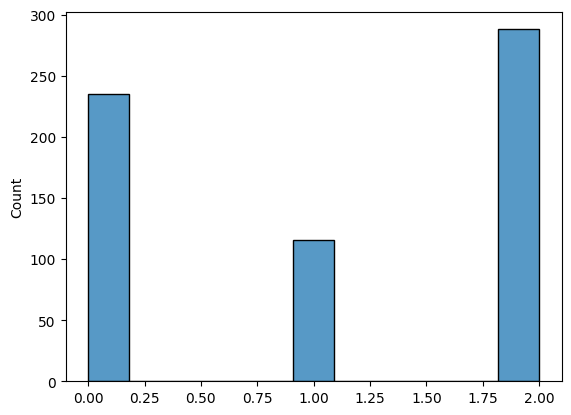

In [219]:
sns.histplot(labels)

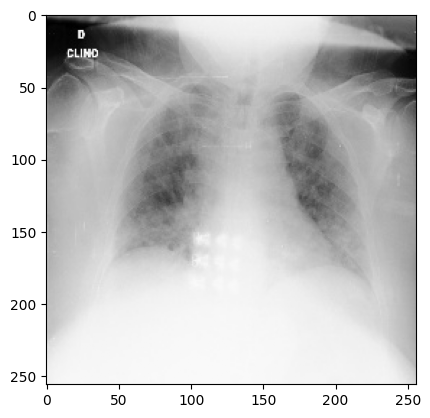

Covid19


In [213]:
plt.imshow(images[1])
plt.show()
print(name_map[labels[1]])

In [214]:
labels[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

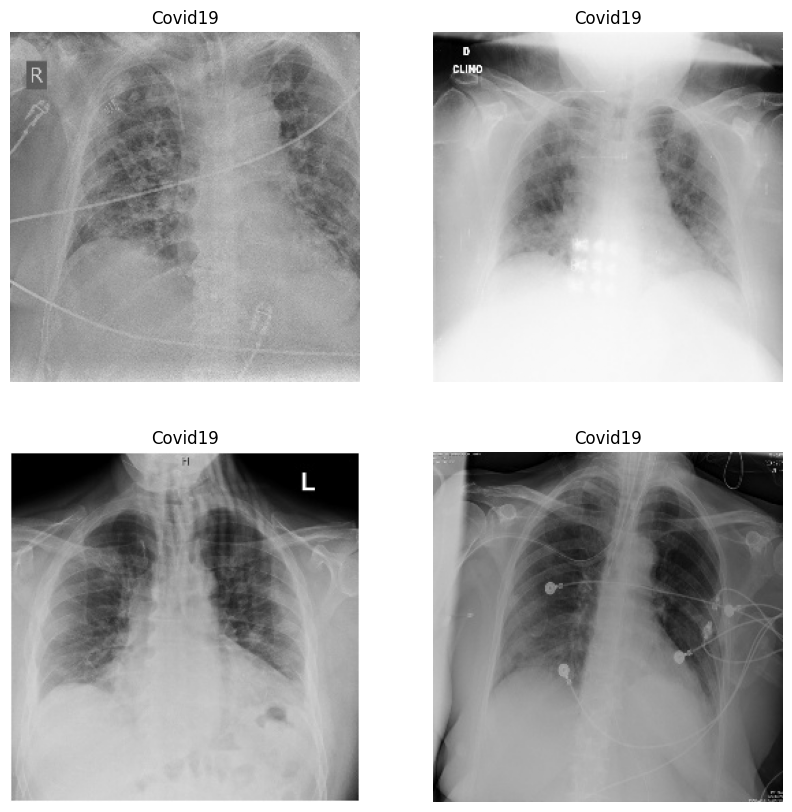

In [215]:
indx = [0,1,2,3] # take four images from different class for visualization
class_label = [0,1,2,5]
index_map = dict(zip(indx, class_label))

plt.figure(figsize=(10, 10))
for i in range(0,4):
  ax = plt.subplot(2, 2, i%4+1)
  plt.imshow(images[index_map[i]])
  plt.title(name_map[int(labels[class_label[i]])])
  plt.axis("off")


In [216]:
path_var_new = dir + 'Npy/new_train/' 
np.save(path_var_new + 'images_origin', images)
np.save(path_var_new + 'labels',labels)
np.save(path_var_new + 'image_names',np.asarray(image_names))

In [220]:
path_var_new = dir + 'Npy/new_test/' 
np.save(path_var_new + 'images_origin', images)
np.save(path_var_new + 'labels',labels)
np.save(path_var_new + 'image_names',np.asarray(image_names))

### Augmentation

In [254]:
path_var = dir + 'Data/train/'
path_var_new = dir + 'Npy/new_train/'
path_var_new2 = dir + 'Npy/new_test/'
train_aug = np.load(path_var_new + 'images_origin.npy')
test_aug = np.load(path_var_new2 + 'images_origin.npy')

dtype('float32')

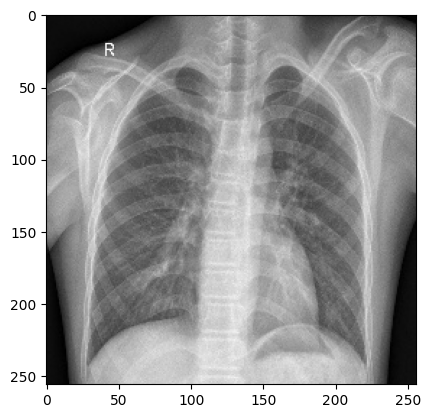

In [255]:
test_pic = plt.imread(path_var + 'NORMAL.7.jpg')
test_pic = resize(test_pic,(256,256,3)).astype(np.float32)
plt.imshow(test_pic)
test_pic.dtype

dtype('float32')

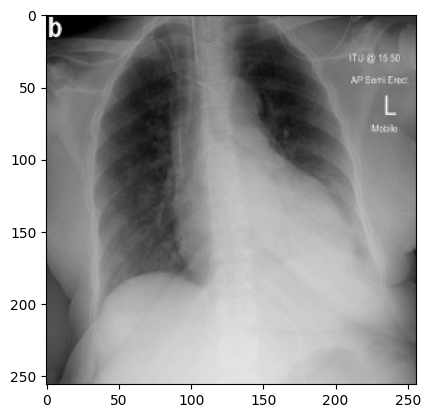

In [256]:
test_pic = plt.imread(path_var + 'COVID19.7.jpg')
test_pic = resize(test_pic,(256,256,3)).astype(np.float32)
plt.imshow(test_pic)
test_pic.dtype

dtype('float32')

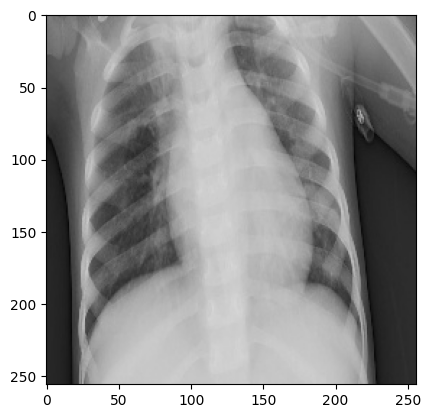

In [258]:
test_pic = plt.imread(path_var + 'PNEUMONIA.430.jpg')
test_pic = resize(test_pic,(256,256,3)).astype(np.float32)
plt.imshow(test_pic)
test_pic.dtype

## Non NN Model w/o Data Aug.

### Random Forest

In [245]:
path_var = dir + 'Npy/new_train/'
images = np.load(path_var + 'images_origin.npy') # read data
labels = np.load(path_var + 'labels.npy')
image_names = np.load(path_var + 'image_names.npy')

In [246]:
def print_results(results): # function for print hyperparameter value and model accuracy
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [247]:
num_img, xdim, ydim, channel = images.shape
x_nonNN = images.reshape((num_img, xdim * ydim * channel)) # reshape to 2d array

In [248]:
x_nonNN_train, x_nonNN_valid, y_nonNN_train, y_nonNN_valid = train_test_split(x_nonNN, labels, stratify = labels) # keep the balance of the data (class weight)
print(x_nonNN_train.shape, y_nonNN_train.shape)
print(x_nonNN_valid.shape, y_nonNN_valid.shape)

(1854, 196608) (1854,)
(618, 196608) (618,)


In [249]:
rfcl = RandomForestClassifier(criterion="entropy")
parameters = {
    'n_estimators': [300, 500],
    'max_features': [3, 5, 7],
    'min_samples_leaf': [1, 3, 5]
}

rf_cv = RandomizedSearchCV(rfcl, parameters, verbose = 3, cv = 5)
rf_cv.fit(x_nonNN_train, y_nonNN_train)

print_results(rf_cv)

y_pred = rf_cv.predict(x_nonNN_valid)
print("The confusion matrix is: ")
print(confusion_matrix(y_nonNN_valid, y_pred))

precision, recall, f1, support = precision_recall_fscore_support(y_nonNN_valid, y_pred, average='macro')
print("precision score: %.2f" % (precision))
print("recall score: %.2f" % (recall))
print("f1 score: %.2f" % (f1))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_features=3, min_samples_leaf=5, n_estimators=300;, score=0.925 total time=   5.1s
[CV 2/5] END max_features=3, min_samples_leaf=5, n_estimators=300;, score=0.911 total time=   3.7s
[CV 3/5] END max_features=3, min_samples_leaf=5, n_estimators=300;, score=0.887 total time=   3.1s
[CV 4/5] END max_features=3, min_samples_leaf=5, n_estimators=300;, score=0.900 total time=   3.4s
[CV 5/5] END max_features=3, min_samples_leaf=5, n_estimators=300;, score=0.859 total time=   3.0s
[CV 1/5] END max_features=7, min_samples_leaf=3, n_estimators=500;, score=0.941 total time=   7.9s
[CV 2/5] END max_features=7, min_samples_leaf=3, n_estimators=500;, score=0.914 total time=   7.3s
[CV 3/5] END max_features=7, min_samples_leaf=3, n_estimators=500;, score=0.884 total time=   8.5s
[CV 4/5] END max_features=7, min_samples_leaf=3, n_estimators=500;, score=0.919 total time=   7.2s
[CV 5/5] END max_features=7, min_samples_leaf=3,

### KNN

In [259]:
knncl = KNeighborsClassifier(n_neighbors=30, p=2)
# use euclidean distance
# parameters = {
#   'n_neighbors': [30, 35, 40],
#  'weights': ["uniform", "distance"],
#}

#knn_cv = RandomizedSearchCV(knncl, parameters, verbose = 3, cv = 5)
knncl.fit(x_nonNN_train, y_nonNN_train)

#print_results(knncl)

y_pred=knncl.predict(x_nonNN_valid)
print("The confusion matrix is: ")
print(confusion_matrix(y_nonNN_valid,y_pred))

precision,recall,f1,support=precision_recall_fscore_support(y_nonNN_valid,y_pred, average='macro')
accuracy=accuracy_score(y_nonNN_valid, y_pred)
print(accuracy)

The confusion matrix is: 
[[217   0  33]
 [  2 103  10]
 [ 22   0 231]]
0.8915857605177994


## Non NN Model with Data Aug.

### Random Forest:

In [260]:
path_var = dir + 'Data/train/'
path_var_new = dir + 'Npy/new_train/'
path_var_new2 = dir + 'Npy/new_test/'
train_aug = np.load(path_var_new + 'images_origin.npy')
train_label = np.load(path_var_new + 'labels.npy')
test_aug = np.load(path_var_new2 + 'images_origin.npy')
test_labels = np.load(path_var_new2 + 'labels.npy')

In [261]:
train_img, xdim, ydim, channel = train_aug.shape
train_img_aug = train_aug.reshape((train_img, xdim * ydim * channel))
print(train_img_aug.shape)

(2472, 196608)


In [262]:
test_num, xdimT, ydimT, channelT = test_aug.shape
test_img_aug = test_aug.reshape((test_num, xdimT * ydimT * channelT))
print(test_img_aug.shape)

(639, 196608)


In [263]:
rfcl = RandomForestClassifier(criterion="entropy")
parameters = {
    'n_estimators': [300, 500],
    'max_features': [10, 15, 20],
    'min_samples_leaf': [5, 7, 10]
}

rf_cv = RandomizedSearchCV(rfcl, parameters, verbose = 3, cv = 5)
rf_cv.fit(train_img_aug, train_label)

print_results(rf_cv)

y_pred = rf_cv.predict(test_img_aug)
print("The confusion matrix is: ")
print(confusion_matrix(test_labels, y_pred))

precision, recall, f1, support = precision_recall_fscore_support(test_labels, y_pred, average='macro')
print("precision score: %.2f" % (precision))
print("recall score: %.2f" % (recall))
print("f1 score: %.2f" % (f1))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_features=20, min_samples_leaf=5, n_estimators=300;, score=0.875 total time=  13.1s
[CV 2/5] END max_features=20, min_samples_leaf=5, n_estimators=300;, score=0.907 total time=  12.3s
[CV 3/5] END max_features=20, min_samples_leaf=5, n_estimators=300;, score=0.909 total time=  12.0s
[CV 4/5] END max_features=20, min_samples_leaf=5, n_estimators=300;, score=0.826 total time=  18.8s
[CV 5/5] END max_features=20, min_samples_leaf=5, n_estimators=300;, score=0.929 total time=  19.1s
[CV 1/5] END max_features=20, min_samples_leaf=7, n_estimators=500;, score=0.865 total time=  26.2s
[CV 2/5] END max_features=20, min_samples_leaf=7, n_estimators=500;, score=0.907 total time=  25.6s
[CV 3/5] END max_features=20, min_samples_leaf=7, n_estimators=500;, score=0.911 total time=  25.2s
[CV 4/5] END max_features=20, min_samples_leaf=7, n_estimators=500;, score=0.818 total time=  25.1s
[CV 5/5] END max_features=20, min_sampl

### KNN

In [264]:
path_var_new = dir + 'Npy/'

In [265]:
train_aug = np.load(path_var_new + 'new_train/images_origin.npy')
train_label = np.load(path_var_new + 'new_train/labels.npy')
train_img,xdim,ydim,channel=train_aug.shape
train_img_aug=train_aug.reshape((train_img,xdim*ydim*channel))
knncl = KNeighborsClassifier(n_neighbors=30, p=2)
# use euclidean distance
# parameters = {
#   'n_neighbors': [30, 35, 40],
#  'weights': ["uniform", "distance"],
#}

#knn_cv = RandomizedSearchCV(knncl, parameters, verbose = 3, cv = 5)
knncl.fit(train_img_aug, train_label)

#print_results(knncl)

y_pred=knncl.predict(test_img_aug)
print("The confusion matrix is: ")
print(confusion_matrix(test_labels,y_pred))

precision,recall,f1,support=precision_recall_fscore_support(test_labels,y_pred, average='macro')
accuracy=accuracy_score(test_labels, y_pred)
print(accuracy)

The confusion matrix is: 
[[222   2  11]
 [  5 102   9]
 [ 17   2 269]]
0.9280125195618153


In [266]:
test_aug=np.load(path_var_new+'new_test/images_origin.npy')
test_labels=np.load(path_var_new+'new_test/labels.npy')
test_num,xdimT,ydimT,channelT=test_aug.shape
test_img_aug=test_aug.reshape((test_num,xdimT*ydimT*channelT))

In [350]:
y_pred=knncl.predict(test_img_aug)
print("The confusion matrix is: ")
cm_res = confusion_matrix(test_labels,y_pred)
print(cm_res)

precision,recall,f1,support=precision_recall_fscore_support(test_labels,y_pred, average='macro')
accuracy=accuracy_score(test_labels, y_pred)
print(accuracy)

The confusion matrix is: 
[[222   2  11]
 [  5 102   9]
 [ 17   2 269]]
0.9280125195618153


Confusion matrix of test data
[[222   2  11]
 [  5 102   9]
 [ 17   2 269]]


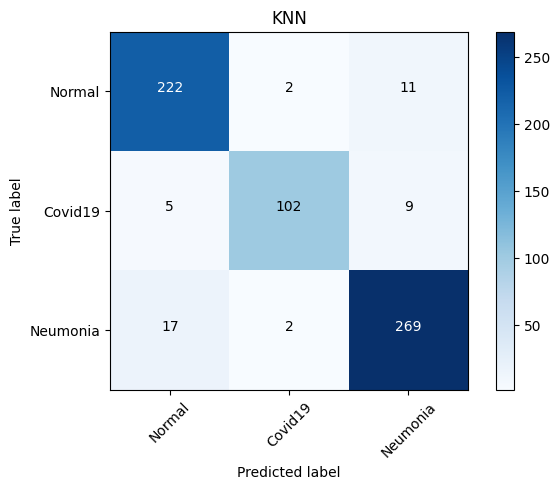

In [352]:
#cm_res = confusion_matrix(y_true, pred)
import itertools
# note - this confusion matrix code was taken from https://deeplizard.com/learn/video/km7pxKy4UHU
def plot_confusion_matrix(cm, classes, title='KNN', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print("Confusion matrix of test data")
    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(cm_res,['Normal','Covid19','Neumonia'])

## NN Model Baseline w/o Aug:

### Load data for NN:

In [268]:
path_var = dir + 'Npy/new_train/' 
images = np.load(path_var + 'images_origin.npy')
labels = np.load(path_var + 'labels.npy')
image_names = np.load(path_var + 'image_names.npy')


In [269]:
print(images.shape, labels.shape, len(image_names))

(2472, 256, 256, 3) (2472,) 2472


In [270]:
print(np.min(images), np.max(images))

0.0 1.0


In [271]:
labels_cat = keras.utils.to_categorical(labels, 3)

In [272]:
labels_cat

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [273]:
test_label = np.argmax(labels_cat,axis=-1) # change back to original
test_label

array([1, 1, 1, ..., 2, 2, 2], dtype=int64)

In [274]:
x_train, x_test, y_train, y_test = train_test_split(images, labels.astype(int), test_size=0.2, random_state=42, stratify=labels.astype(int))

In [275]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1977, 256, 256, 3) (495, 256, 256, 3) (1977,) (495,)


In [276]:
y_train = keras.utils.to_categorical(y_train, 3)
y_test = keras.utils.to_categorical(y_test, 3)

In [277]:
print(y_train.shape, y_test.shape)

(1977, 3) (495, 3)


### VGG16:

In [282]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(3, activation='softmax')(x)

model_vgg_pre = Model(base_model.input,x)
for layer in base_model.layers:
  layer.trainable = False

model_vgg_pre.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0000001), loss = 'categorical_crossentropy', metrics=[keras.metrics.CategoricalAccuracy()])

model_vgg_pre.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [283]:
history_vgg_pre = model_vgg_pre.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=4, verbose=2)

Epoch 1/20
495/495 - 1362s - loss: 1.1781 - categorical_accuracy: 0.4057 - val_loss: 1.0226 - val_categorical_accuracy: 0.4182 - 1362s/epoch - 3s/step
Epoch 2/20
495/495 - 1668s - loss: 0.9555 - categorical_accuracy: 0.5478 - val_loss: 0.9123 - val_categorical_accuracy: 0.6081 - 1668s/epoch - 3s/step
Epoch 3/20
495/495 - 2398s - loss: 0.8695 - categorical_accuracy: 0.6748 - val_loss: 0.8373 - val_categorical_accuracy: 0.6909 - 2398s/epoch - 5s/step
Epoch 4/20
495/495 - 2125s - loss: 0.8009 - categorical_accuracy: 0.7279 - val_loss: 0.7726 - val_categorical_accuracy: 0.7414 - 2125s/epoch - 4s/step
Epoch 5/20
495/495 - 1884s - loss: 0.7412 - categorical_accuracy: 0.7547 - val_loss: 0.7168 - val_categorical_accuracy: 0.7778 - 1884s/epoch - 4s/step
Epoch 6/20
495/495 - 11274s - loss: 0.6891 - categorical_accuracy: 0.7977 - val_loss: 0.6680 - val_categorical_accuracy: 0.8141 - 11274s/epoch - 23s/step
Epoch 7/20
495/495 - 769s - loss: 0.6431 - categorical_accuracy: 0.8225 - val_loss: 0.6248 

In [284]:
model_vgg_pre.evaluate(x_test, y_test)

16/16 [==============================] - 120s 8s/step - loss: 0.3371 - categorical_accuracy: 0.9455


[0.3371330201625824, 0.9454545378684998]

In [285]:
pred = model_vgg_pre.predict(x_test)
y_true = np.argmax(y_test, axis = -1)
pred = np.argmax(pred,axis=-1)

16/16 [==============================] - 132s 8s/step


In [286]:
def inverse_categorical(target):
  target = np.argmax(pred,axis=-1)
  return target

Confusion matrix of test data
[[190   1   9]
 [  0  87   5]
 [ 11   1 191]]


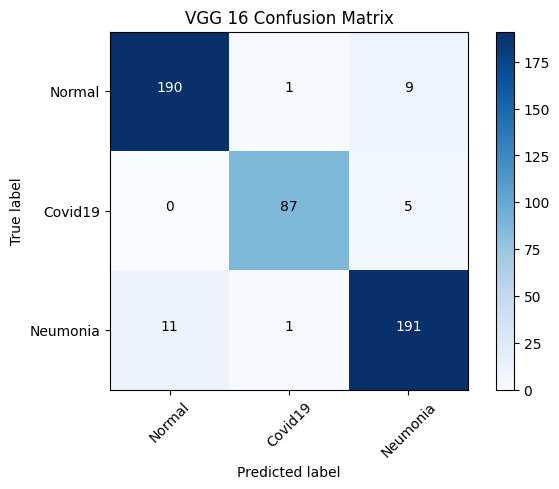

In [292]:
cm = confusion_matrix(y_true, pred)
import itertools
# note - this confusion matrix code was taken from https://deeplizard.com/learn/video/km7pxKy4UHU
def plot_confusion_matrix(cm, classes, title='VGG 16 Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print("Confusion matrix of test data")
    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(cm,['Normal','Covid19','Neumonia'])

### ResNet50:

In [290]:
# reference: https://zhuanlan.zhihu.com/p/54289848
base_model_resnet = ResNet50(include_top=False, weights="imagenet", input_shape=(256, 256, 3), pooling="avg")

output = base_model_resnet.output
for layer in base_model_resnet.layers:
  layer.trainable = False
y = Dense(3, activation='softmax')(output)
model_resnet_pre = Model(base_model_resnet.input,y)

model_resnet_pre.compile(optimizer = keras.optimizers.Adam(learning_rate=0.00001), loss = 'categorical_crossentropy', metrics=[keras.metrics.CategoricalAccuracy()])

model_resnet_pre.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_11[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [291]:
history_resnet_pre = model_resnet_pre.fit(x_train, y_train, validation_split=0.15, epochs=25, batch_size=4, verbose=2)

Epoch 1/25
420/420 - 358s - loss: 1.3661 - categorical_accuracy: 0.3357 - val_loss: 1.1457 - val_categorical_accuracy: 0.4545 - 358s/epoch - 853ms/step
Epoch 2/25
420/420 - 364s - loss: 1.0903 - categorical_accuracy: 0.3964 - val_loss: 1.0241 - val_categorical_accuracy: 0.4545 - 364s/epoch - 866ms/step
Epoch 3/25
420/420 - 359s - loss: 1.0497 - categorical_accuracy: 0.3679 - val_loss: 1.0066 - val_categorical_accuracy: 0.3367 - 359s/epoch - 856ms/step
Epoch 4/25
420/420 - 368s - loss: 1.0454 - categorical_accuracy: 0.3321 - val_loss: 1.0021 - val_categorical_accuracy: 0.3502 - 368s/epoch - 876ms/step
Epoch 5/25
420/420 - 366s - loss: 1.0436 - categorical_accuracy: 0.3661 - val_loss: 1.0004 - val_categorical_accuracy: 0.3535 - 366s/epoch - 872ms/step
Epoch 6/25
420/420 - 366s - loss: 1.0420 - categorical_accuracy: 0.3893 - val_loss: 0.9963 - val_categorical_accuracy: 0.4411 - 366s/epoch - 872ms/step
Epoch 7/25
420/420 - 364s - loss: 1.0399 - categorical_accuracy: 0.4119 - val_loss: 0.99

In [293]:
model_resnet_pre.evaluate(x_test, y_test)

16/16 [==============================] - 49s 3s/step - loss: 1.0042 - categorical_accuracy: 0.5737


[1.0041992664337158, 0.573737382888794]

In [306]:
pred = model_resnet_pre.predict(x_test)
y_true = np.argmax(y_test, axis = -1)
pred = np.argmax(pred,axis=-1)

16/16 [==============================] - 91s 6s/step


In [307]:
cm_res = confusion_matrix(y_true, pred)
print(cm_res)

[[ 90   0 110]
 [  5   0  87]
 [  9   0 194]]


Confusion matrix of test data
[[ 90   0 110]
 [  5   0  87]
 [  9   0 194]]


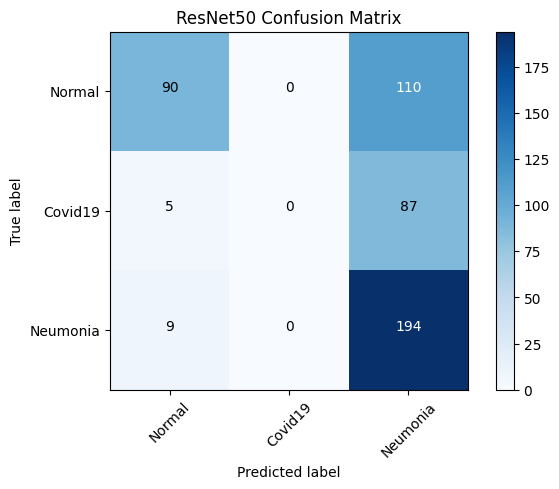

In [308]:
#cm_res = confusion_matrix(y_true, pred)
import itertools
# note - this confusion matrix code was taken from https://deeplizard.com/learn/video/km7pxKy4UHU
def plot_confusion_matrix(cm, classes, title='ResNet50 Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print("Confusion matrix of test data")
    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(cm_res,['Normal','Covid19','Neumonia'])

In [301]:
output = base_model_resnet.output
for layer in base_model_resnet.layers:
  layer.trainable = False
y = Dense(3, activation='softmax')(output)
model_resnet_pre2 = Model(base_model_resnet.input,y)

model_resnet_pre2.compile(optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9), loss = 'categorical_crossentropy', metrics=[keras.metrics.CategoricalAccuracy()])

model_resnet_pre2.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_11[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [302]:
history_resnet_pre2 = model_resnet_pre2.fit(x_train, y_train, validation_split=0.1, epochs=25, batch_size=4, verbose=2, shuffle=True)

Epoch 1/25
445/445 - 359s - loss: 16.4083 - categorical_accuracy: 0.4064 - val_loss: 0.7784 - val_categorical_accuracy: 0.7071 - 359s/epoch - 808ms/step
Epoch 2/25
445/445 - 375s - loss: 12.3527 - categorical_accuracy: 0.4547 - val_loss: 28.7313 - val_categorical_accuracy: 0.1263 - 375s/epoch - 843ms/step
Epoch 3/25
445/445 - 378s - loss: 12.7247 - categorical_accuracy: 0.4609 - val_loss: 2.3830 - val_categorical_accuracy: 0.6313 - 378s/epoch - 850ms/step
Epoch 4/25
445/445 - 378s - loss: 7.4056 - categorical_accuracy: 0.5239 - val_loss: 5.6000 - val_categorical_accuracy: 0.4293 - 378s/epoch - 850ms/step
Epoch 5/25
445/445 - 374s - loss: 7.2101 - categorical_accuracy: 0.5379 - val_loss: 8.2102 - val_categorical_accuracy: 0.6010 - 374s/epoch - 841ms/step
Epoch 6/25
445/445 - 374s - loss: 6.5457 - categorical_accuracy: 0.5436 - val_loss: 6.6351 - val_categorical_accuracy: 0.6010 - 374s/epoch - 840ms/step
Epoch 7/25
445/445 - 373s - loss: 6.7429 - categorical_accuracy: 0.5481 - val_loss: 

In [303]:
model_resnet_pre2.evaluate(x_test, y_test)

16/16 [==============================] - 72s 5s/step - loss: 1.0042 - categorical_accuracy: 0.5737


[1.0041992664337158, 0.573737382888794]

In [309]:
pred = model_resnet_pre2.predict(x_test)
y_true = np.argmax(y_test, axis = -1)
pred = np.argmax(pred,axis=-1)

16/16 [==============================] - 94s 6s/step


In [310]:
cm_res = confusion_matrix(y_true, pred)
print(cm_res)

[[  0   1 199]
 [  1  65  26]
 [  0  10 193]]


Confusion matrix of test data
[[  0   1 199]
 [  1  65  26]
 [  0  10 193]]


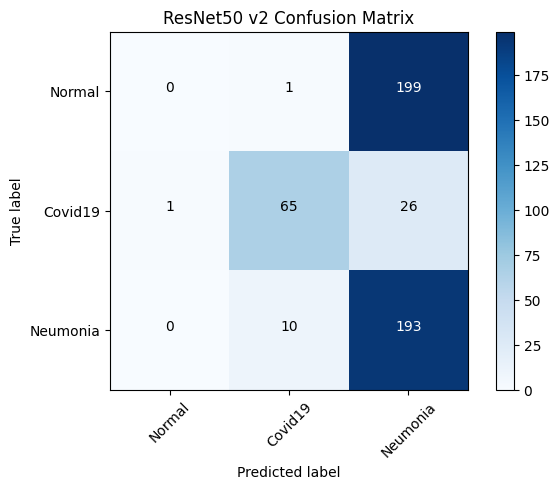

In [311]:
#cm_res = confusion_matrix(y_true, pred)
import itertools
# note - this confusion matrix code was taken from https://deeplizard.com/learn/video/km7pxKy4UHU
def plot_confusion_matrix(cm, classes, title='ResNet50 v2 Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print("Confusion matrix of test data")
    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(cm_res,['Normal','Covid19','Neumonia'])

### Inception

In [4]:
path_var = dir + 'Npy/new_train/' 
images = np.load(path_var + 'images_origin.npy')
labels = np.load(path_var + 'labels.npy')

In [10]:
x_train, x_test, y_train, y_test = train_test_split(images, labels.astype(int), test_size=0.2, random_state=42, stratify=labels.astype(int))
y_train = keras.utils.to_categorical(y_train, 3)
y_test = keras.utils.to_categorical(y_test, 3)

In [5]:
def add_new_last_layer(base_model, nb_classes):
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = Dense(256, activation='relu')(x) #new FC layer, random init
  predictions = Dense(nb_classes, activation='softmax')(x) #new softmax layer
  model = Model(base_model.input, predictions)
  return model

In [6]:
def setup_to_transfer_learn(model, base_model):
  """Freeze all layers and compile the model"""
  for layer in base_model.layers:
    layer.trainable = False
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
base_model = InceptionV3(weights='imagenet', include_top=False) 
model = add_new_last_layer(base_model, 3)              
setup_to_transfer_learn(model, base_model)

In [11]:
history_inception = model.fit(x_train, y_train, epochs=25, batch_size=4, validation_split=0.1)

Epoch 1/25
445/445 [==============================] - 87s 191ms/step - loss: 0.4313 - accuracy: 0.8331 - val_loss: 0.2669 - val_accuracy: 0.8939
Epoch 2/25
445/445 [==============================] - 87s 195ms/step - loss: 0.2455 - accuracy: 0.9095 - val_loss: 0.2992 - val_accuracy: 0.8990
Epoch 3/25
445/445 [==============================] - 90s 202ms/step - loss: 0.1955 - accuracy: 0.9309 - val_loss: 0.3283 - val_accuracy: 0.8939
Epoch 4/25
445/445 [==============================] - 91s 203ms/step - loss: 0.1684 - accuracy: 0.9432 - val_loss: 0.2147 - val_accuracy: 0.9192
Epoch 5/25
445/445 [==============================] - 90s 202ms/step - loss: 0.1425 - accuracy: 0.9460 - val_loss: 0.4706 - val_accuracy: 0.8182
Epoch 6/25
445/445 [==============================] - 92s 206ms/step - loss: 0.1267 - accuracy: 0.9539 - val_loss: 0.2407 - val_accuracy: 0.9192
Epoch 7/25
445/445 [==============================] - 93s 209ms/step - loss: 0.1338 - accuracy: 0.9511 - val_loss: 0.2293 - val_ac

In [12]:
model.evaluate(x_test, y_test)

16/16 [==============================] - 17s 1s/step - loss: 0.2999 - accuracy: 0.9232


[0.29986974596977234, 0.9232323169708252]

In [13]:
pred_in = model.predict(x_test)
pred_in = np.argmax(pred_in,axis=-1)
true_labels = np.argmax(y_test,axis=-1)
test_results = list(precision_recall_fscore_support(true_labels, pred_in, average = 'macro')[:-1])
test_results

16/16 [==============================] - 18s 1s/step


[0.9261598910900709, 0.9372824302134647, 0.9310522060446056]

In [14]:
NB_IV3_LAYERS_TO_FREEZE = 172

In [15]:
def setup_to_finetune(model):
  for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
     layer.trainable = False
  for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
     layer.trainable = True
  model.compile(keras.optimizers.SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
#base_model = InceptionV3(weights='imagenet', include_top=False)
model_ince2 = add_new_last_layer(base_model, 3)             
setup_to_finetune(model_ince2)

In [17]:
history_inception2 = model_ince2.fit(x_train, y_train, epochs=25, batch_size=4, validation_split=0.1)

Epoch 1/25
445/445 [==============================] - 193s 426ms/step - loss: 0.4721 - accuracy: 0.8224 - val_loss: 1.0068 - val_accuracy: 0.7525
Epoch 2/25
445/445 [==============================] - 194s 436ms/step - loss: 0.2683 - accuracy: 0.9117 - val_loss: 0.2856 - val_accuracy: 0.9242
Epoch 3/25
445/445 [==============================] - 202s 454ms/step - loss: 0.1436 - accuracy: 0.9567 - val_loss: 0.1280 - val_accuracy: 0.9646
Epoch 4/25
445/445 [==============================] - 205s 460ms/step - loss: 0.1405 - accuracy: 0.9562 - val_loss: 0.3689 - val_accuracy: 0.8939
Epoch 5/25
445/445 [==============================] - 212s 477ms/step - loss: 0.1145 - accuracy: 0.9629 - val_loss: 0.1413 - val_accuracy: 0.9545
Epoch 6/25
445/445 [==============================] - 210s 473ms/step - loss: 0.0666 - accuracy: 0.9792 - val_loss: 0.2987 - val_accuracy: 0.8838
Epoch 7/25
445/445 [==============================] - 206s 463ms/step - loss: 0.0481 - accuracy: 0.9837 - val_loss: 0.3993 -

### Vision Transformer from sratch

Reference https://keras.io/examples/vision/image_classification_with_vision_transformer/

In [312]:
import tensorflow_addons as tfa
from vit_keras import vit

In [313]:
!pip install tensorflow_addons
import tensorflow_addons as tfa
!pip install --quiet vit-keras
from vit_keras import vit

In [315]:
path_var = dir + 'Npy/new_train/'

labels = np.load(path_var + 'labels.npy')
images_raw = np.load(path_var + 'images_origin.npy')

In [316]:
x_train, x_test, y_train, y_test = train_test_split(images_raw, labels.astype(int), test_size=0.2, random_state=42, stratify=labels.astype(int))

In [317]:
y_train_cat = keras.utils.to_categorical(y_train, 3)

In [318]:
y_test_cat = keras.utils.to_categorical(y_test, 3)

In [334]:
def mlp_layer(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = keras.layers.Dense(units, activation = tf.nn.gelu)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
    return x

class Patches(keras.layers.Layer): # split image to small blocks
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Visualize the effect of different patch size

(-0.5, 255.5, 255.5, -0.5)

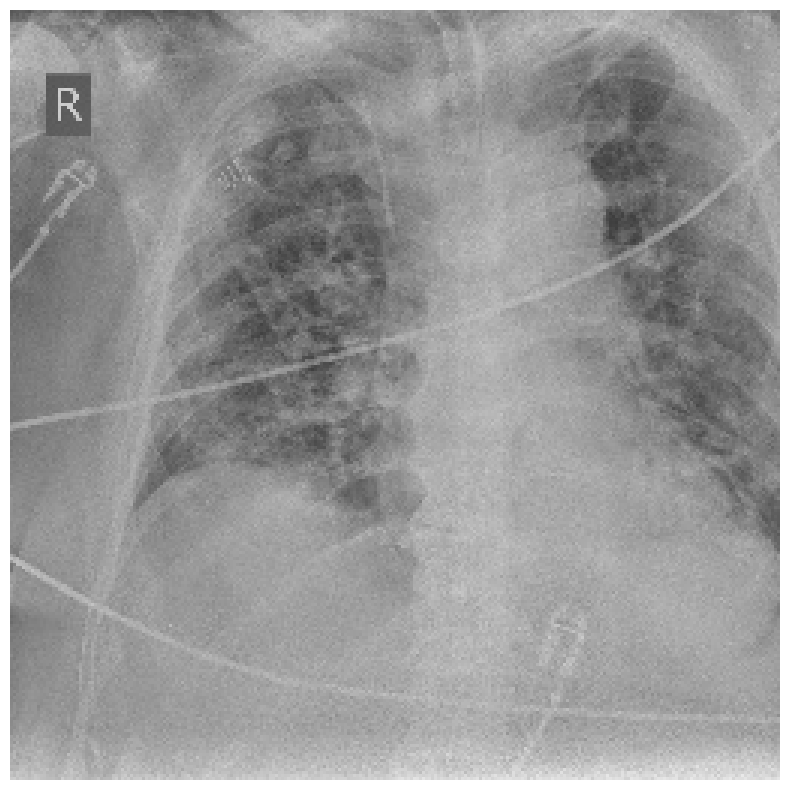

In [335]:
plt.figure(figsize=(10, 10))
plt.imshow(images_raw[0])
plt.axis('off')

In [336]:
test_img = images_raw[0]
new_img = tf.expand_dims(test_img, axis=0)
print(np.min(new_img), np.max(new_img))

0.23921569 0.9137255


In [338]:
def create_patch(patch_size, img):
  patches = Patches(patch_size)(img)
  print(f'Image size: {256} X {256}')
  print(f'Patch size: {patch_size} X {patch_size}')
  print(f'Patches per image: {patches.shape[1]}')
  print(f'Elements per patch: {patches.shape[-1]}')
  return patches
patches_att = create_patch(10, new_img)

Image size: 256 X 256
Patch size: 10 X 10
Patches per image: 625
Elements per patch: 300


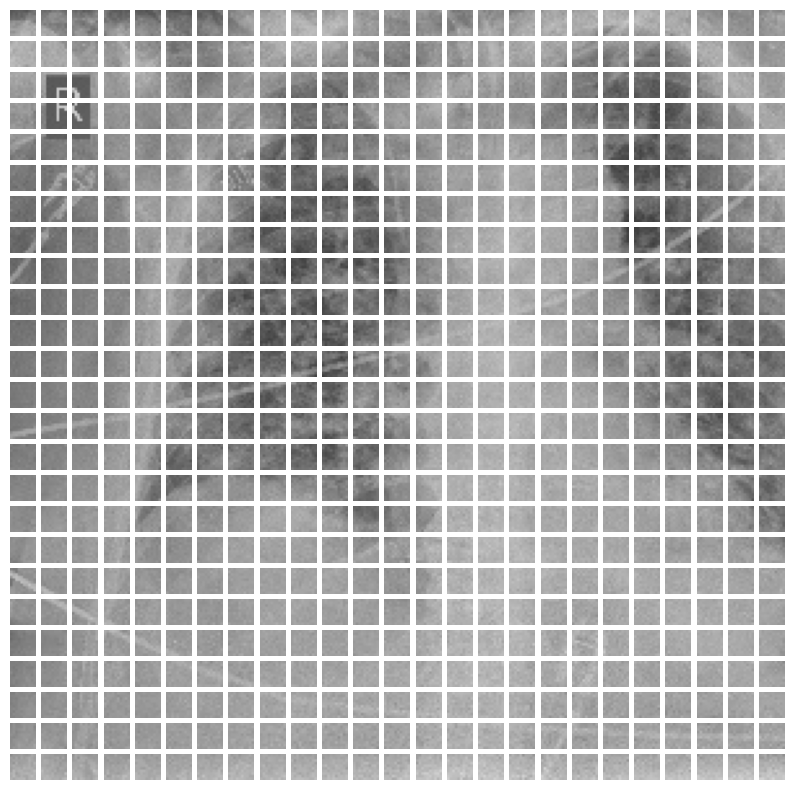

In [339]:
def plot_attention(patches, patch_size):
  n = int(np.sqrt(patches.shape[1]))
  plt.figure(figsize=(10, 10))

  for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('float32'))
    plt.axis('off')

plot_attention(patches_att, 10)

(-0.5, 255.5, 255.5, -0.5)

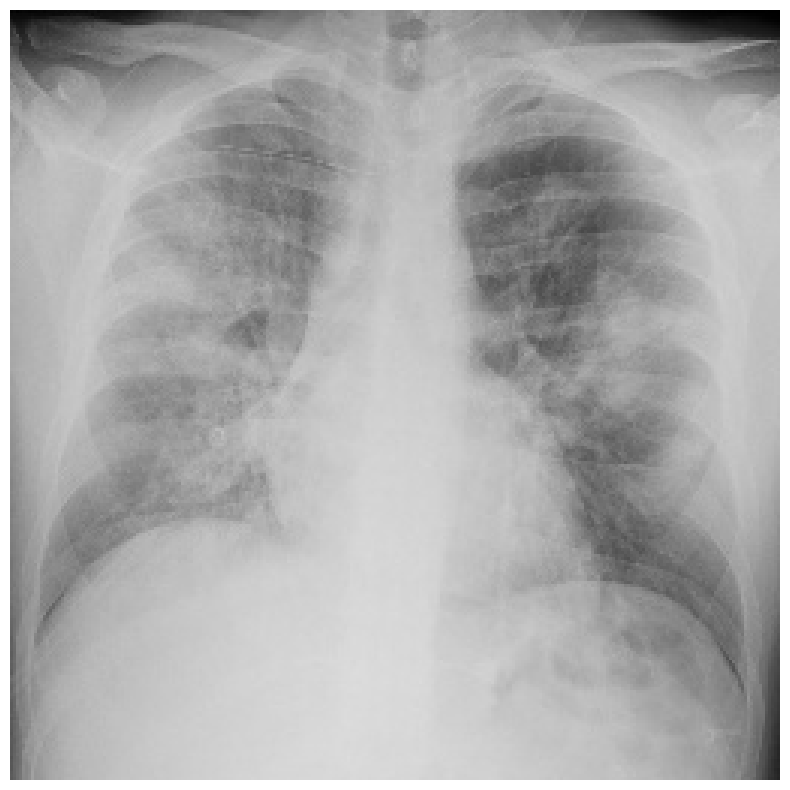

In [340]:
plt.figure(figsize=(10, 10))
plt.imshow(images_raw[32])
plt.axis('off')

In [341]:
test_img = images_raw[32]
new_img = tf.expand_dims(test_img, axis=0)
print(np.min(new_img), np.max(new_img))

patches_att = create_patch(20, new_img)

0.0 0.8627451
Image size: 256 X 256
Patch size: 20 X 20
Patches per image: 144
Elements per patch: 1200


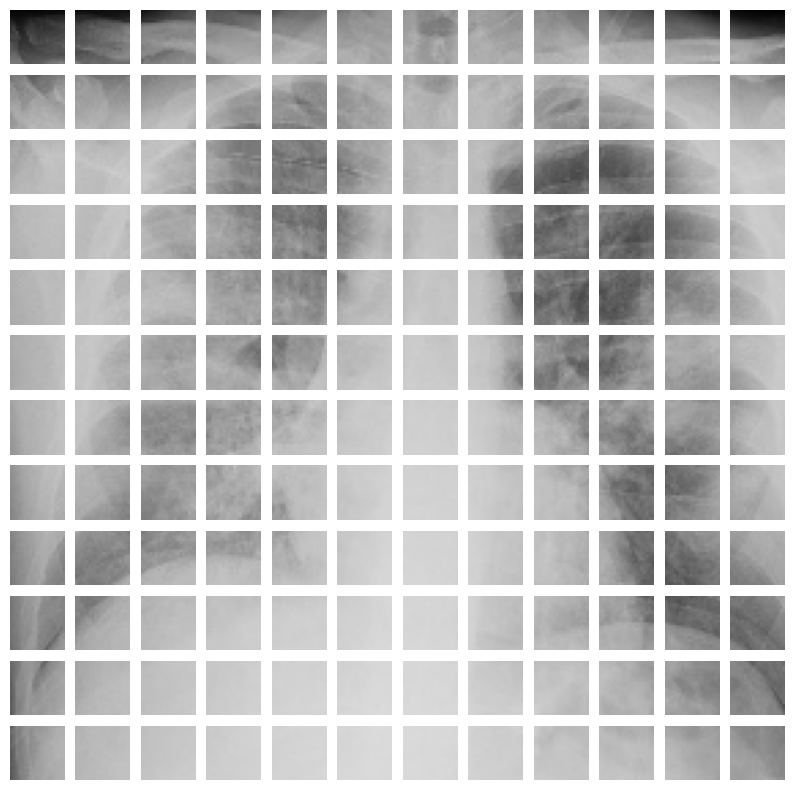

In [342]:
plot_attention(patches_att, 20)

In [343]:
# Vision Transformer hyper parameters
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 25 # default

patch_size = 20  # Size of the patches to be extract from the input images
num_patches = (256 // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [344]:
class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = keras.layers.Dense(units = projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim = num_patches, output_dim = projection_dim
        )

    def call(self, patch):
        positions = tf.range(start = 0, limit = self.num_patches, delta = 1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def vision_transformer():
    inputs = keras.layers.Input(shape = (256, 256, 3))
    
    # Create patches.
    patches = Patches(patch_size)(inputs)
    
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        
        # Layer normalization 1.
        x = keras.layers.LayerNormalization(epsilon = 1e-5)(encoded_patches)
        
        # Create a multi-head attention layer.
        attention_output = keras.layers.MultiHeadAttention(
            num_heads = num_heads, key_dim = projection_dim, dropout = 0.1
        )(x, x)
        
        # Skip connection 1.
        y = keras.layers.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2.
        z = keras.layers.LayerNormalization(epsilon = 1e-5)(y)
        
        # MLP.
        z = mlp_layer(z, hidden_units = transformer_units, dropout_rate = 0.1)
        
        # Skip connection 2.
        encoded_patches = keras.layers.Add()([z, y])

    # Create tensor.
    representation = keras.layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)
    representation = keras.layers.Flatten()(representation)
    representation = keras.layers.Dropout(0.5)(representation)
    
    # Add MLP layer
    features = mlp_layer(representation, hidden_units = mlp_head_units, dropout_rate = 0.5)
    
    # Classify outputs.
    logits = keras.layers.Dense(4)(features)
    
    # Create the model.
    model = tf.keras.Model(inputs = inputs, outputs = logits)
    
    return model

In [345]:
decay_steps = 10
initial_learning_rate = learning_rate
lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate, decay_steps)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)

optimizer = tfa.optimizers.AdamW(learning_rate = learning_rate, weight_decay=weight_decay)

model = vision_transformer()
    
model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics = [keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

# earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
#                                                  min_delta = 1e-4,
#                                                  patience = 5,
#                                                  mode = 'max',
#                                                  restore_best_weights = True,
#                                                  verbose = 1)

callbacks = [lr_scheduler]

# labels = keras.utils.to_categorical(labels, 3)

model.fit(x_train, y_train, epochs = 100, batch_size = 4, validation_split=0.2)

Epoch 1/100
396/396 [==============================] - 347s 854ms/step - loss: 5.6634 - accuracy: 0.5281 - val_loss: 0.6479 - val_accuracy: 0.6944
Epoch 2/100
396/396 [==============================] - 356s 899ms/step - loss: 0.7876 - accuracy: 0.7179 - val_loss: 0.5769 - val_accuracy: 0.6944
Epoch 3/100
396/396 [==============================] - 363s 916ms/step - loss: 0.5320 - accuracy: 0.7875 - val_loss: 0.4177 - val_accuracy: 0.8157
Epoch 4/100
396/396 [==============================] - 366s 925ms/step - loss: 0.4849 - accuracy: 0.8140 - val_loss: 0.3966 - val_accuracy: 0.8535
Epoch 5/100
396/396 [==============================] - 369s 931ms/step - loss: 0.4775 - accuracy: 0.8248 - val_loss: 0.4900 - val_accuracy: 0.7879
Epoch 6/100
396/396 [==============================] - 375s 948ms/step - loss: 0.4139 - accuracy: 0.8450 - val_loss: 0.3705 - val_accuracy: 0.8586
Epoch 7/100
396/396 [==============================] - 373s 942ms/step - loss: 0.4640 - accuracy: 0.8400 - val_loss: 0

In [346]:
model.evaluate(x_test, y_test)

16/16 [==============================] - 26s 1s/step - loss: 0.3719 - accuracy: 0.8909


[0.3719174265861511, 0.8909090757369995]

In [347]:
vit_pred = model.predict(images_raw)
#list(precision_recall_fscore_support(int(labels), np.argmax(vit_pred,axis=-1), average = 'macro')[:-1])
vit_pred = np.argmax(vit_pred, axis=-1)

78/78 [==============================] - 146s 2s/step


In [348]:
list(precision_recall_fscore_support(labels, vit_pred, average = 'macro')[:-1])

[0.9548390218655968, 0.9534608856502805, 0.9537683270790787]

In [349]:
accuracy_score(labels, vit_pred)

0.9490291262135923

### Vision Transformer Fine Tune:

Reference：https://github.com/faustomorales/vit-keras/blob/1805a98633c5094a7a45f8535f91364b143f4f26/vit_keras/vit.py#L123

In [353]:
vit_model = vit.vit_b32( # fine tune the top layer
        image_size = 256,
        activation = 'softmax',
        pretrained = True,
        include_top = True,
        pretrained_top = False,
        classes = 3)

vit_model.summary()

c:\Users\luzma\Desktop\MAESTRIA\VA\Laboratorio\venv\Lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 8, 8
  warnings.warn(


Model: "vit-b32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 8, 8, 768)         2360064   
                                                                 
 reshape_4 (Reshape)         (None, 64, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 65, 768)           768       
                                                                 
 Transformer/posembed_input   (None, 65, 768)          49920     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 65, 768),        7087872   
 (TransformerBlock)           (None, 12, None, None))      

In [354]:
initial_learning_rate = 3e-5

lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate, 5)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)

optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-5)

# model_vitFT.compile(optimizer = optimizer, 
#               loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1), 
#               metrics = ['accuracy'])
vit_model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1), 
              metrics = ['accuracy'])

#model_vitFT.fit(images_raw, labels_cat, batch_size = 4, validation_split = 0.1, epochs=25, callbacks=[lr_scheduler])
vit_model.fit(x_train, y_train_cat, batch_size = 8, validation_split = 0.1, epochs=25, callbacks=[lr_scheduler])

Epoch 1/25
223/223 [==============================] - 1538s 7s/step - loss: 0.4794 - accuracy: 0.9078 - val_loss: 0.4060 - val_accuracy: 0.9444 - lr: 3.0000e-05
Epoch 2/25
223/223 [==============================] - 1508s 7s/step - loss: 0.3751 - accuracy: 0.9668 - val_loss: 0.3639 - val_accuracy: 0.9596 - lr: 2.7135e-05
Epoch 3/25
223/223 [==============================] - 1460s 7s/step - loss: 0.3406 - accuracy: 0.9815 - val_loss: 0.3497 - val_accuracy: 0.9747 - lr: 1.9635e-05
Epoch 4/25
223/223 [==============================] - 1552s 7s/step - loss: 0.3247 - accuracy: 0.9876 - val_loss: 0.3556 - val_accuracy: 0.9697 - lr: 1.0365e-05
Epoch 5/25
223/223 [==============================] - 1150s 5s/step - loss: 0.3128 - accuracy: 0.9955 - val_loss: 0.3578 - val_accuracy: 0.9697 - lr: 2.8647e-06
Epoch 6/25
223/223 [==============================] - 1123s 5s/step - loss: 0.3098 - accuracy: 0.9972 - val_loss: 0.3578 - val_accuracy: 0.9697 - lr: 0.0000e+00
Epoch 7/25
223/223 [==============

In [355]:
vit_model.evaluate(x_test, y_test_cat)

16/16 [==============================] - 39s 2s/step - loss: 0.3705 - accuracy: 0.9616


[0.370543897151947, 0.9616161584854126]

In [328]:
path_var2 = dir + 'Npy/new_test/'

In [329]:
test_images = np.load(path_var2 + 'images_origin.npy')
test_label = np.load(path_var2 + 'labels.npy')

In [356]:
vit_pred = vit_model.predict(test_images)
vit_pred = np.argmax(vit_pred,axis=-1)
precision_recall_fscore_support(test_label, vit_pred)

20/20 [==============================] - 57s 3s/step


(array([0.88549618, 1.        , 0.98854962]),
 array([0.98723404, 0.99137931, 0.89930556]),
 array([0.93360161, 0.995671  , 0.94181818]),
 array([235, 116, 288], dtype=int64))

In [319]:
vit_model2 = vit.vit_b32(
        image_size = 256,
        activation = 'softmax',
        pretrained = True,
        include_top = True,
        pretrained_top = False,
        classes = 3,
        weights="imagenet21k+imagenet2012")

vit_model2.summary()

c:\Users\luzma\Desktop\MAESTRIA\VA\Laboratorio\venv\Lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 8, 8
  warnings.warn(


Model: "vit-b32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 8, 8, 768)         2360064   
                                                                 
 reshape_3 (Reshape)         (None, 64, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 65, 768)           768       
                                                                 
 Transformer/posembed_input   (None, 65, 768)          49920     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 65, 768),        7087872   
 (TransformerBlock)           (None, 12, None, None))      

In [320]:
initial_learning_rate = 3e-5

lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate, 10)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)

optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-5)

# model_vitFT.compile(optimizer = optimizer, 
#               loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1), 
#               metrics = ['accuracy'])
vit_model2.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 1e-4, patience = 8, mode = 'max', restore_best_weights = True, verbose = 1)

#model_vitFT.fit(images_raw, labels_cat, batch_size = 4, validation_split = 0.1, epochs=50, callbacks=[lr_scheduler])
vit_model2.fit(x_train, y_train_cat, batch_size = 8, validation_split = 0.1, epochs=50, callbacks=[early_stopping])

Epoch 1/50
223/223 [==============================] - 1448s 6s/step - loss: 0.6712 - accuracy: 0.8724 - val_loss: 0.5930 - val_accuracy: 0.9343
Epoch 2/50
223/223 [==============================] - 1054s 5s/step - loss: 0.5778 - accuracy: 0.9601 - val_loss: 0.5970 - val_accuracy: 0.9343
Epoch 3/50
223/223 [==============================] - 1078s 5s/step - loss: 0.5489 - accuracy: 0.9758 - val_loss: 0.5871 - val_accuracy: 0.9444
Epoch 4/50
223/223 [==============================] - 1061s 5s/step - loss: 0.5279 - accuracy: 0.9848 - val_loss: 0.5677 - val_accuracy: 0.9596
Epoch 5/50
223/223 [==============================] - 1055s 5s/step - loss: 0.5320 - accuracy: 0.9809 - val_loss: 0.5457 - val_accuracy: 0.9596
Epoch 6/50
223/223 [==============================] - 1059s 5s/step - loss: 0.5123 - accuracy: 0.9916 - val_loss: 0.5643 - val_accuracy: 0.9394
Epoch 7/50
223/223 [==============================] - 1061s 5s/step - loss: 0.5104 - accuracy: 0.9899 - val_loss: 0.5375 - val_accuracy:

In [321]:
vit_model2.evaluate(x_test, y_test_cat)

16/16 [==============================] - 41s 3s/step - loss: 0.5441 - accuracy: 0.9677


[0.5441047549247742, 0.9676767587661743]

In [331]:
vit_pred2 = vit_model2.predict(test_images)
vit_pred2 = np.argmax(vit_pred2,axis=-1)
accuracy_score(test_label, vit_pred2)

20/20 [==============================] - 52s 3s/step


0.9577464788732394

In [332]:
list(precision_recall_fscore_support(test_label, vit_pred2, average = 'macro')[:-1])

[0.96500468164794, 0.967966903073286, 0.9654538448835801]

Confusion matrix, without normalization
[[232   0   3]
 [  0 116   0]
 [ 24   0 264]]


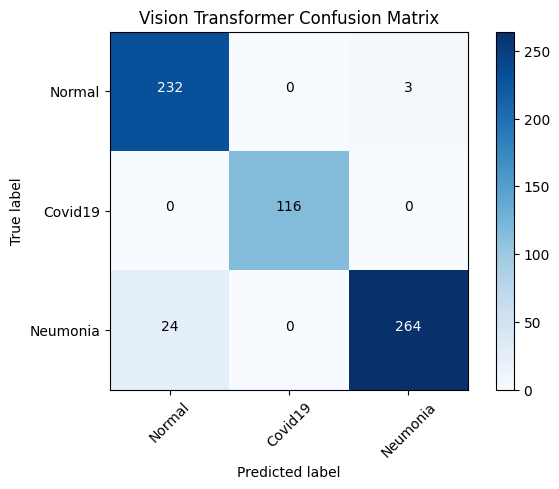

In [333]:
cm = confusion_matrix(test_label, vit_pred2)
import itertools
# Reference: https://deeplizard.com/learn/video/km7pxKy4UHU
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Vision Transformer Confusion Matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(cm,['Normal','Covid19','Neumonia'])